In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/augmented-forest-segmentation/meta_data.csv
/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/meta_data.csv
/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images/626208_sat_04.jpg
/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images/15573_sat_26.jpg
/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images/749523_sat_70.jpg
/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images/830444_sat_35.jpg
/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images/340898_sat_47.jpg
/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images/563092_sat_47.jpg
/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images/119079_sat_71.jpg
/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images/296279_sat_35.jpg
/kaggle/input/augmented-for

In [2]:
# ✅ STEP 1: Install dependencies (if needed)
!pip install -q tensorflow

# ✅ STEP 2: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

2025-05-01 17:55:37.341725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746122137.623443      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746122137.694828      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# ✅ STEP 3: Prepare dataset paths
image_dir = "/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images"
mask_dir = "/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks"

# Get all image and mask paths
image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]
mask_paths = [os.path.join(mask_dir, img) for img in os.listdir(mask_dir)]

image_paths.sort()
mask_paths.sort()

print("Total Images:", len(image_paths))
print("Total Masks:", len(mask_paths))

Total Images: 5108
Total Masks: 5108


In [4]:
# ✅ STEP 4: Load and preprocess images + masks
IMG_SIZE = 128  # You can increase to 256 if GPU allows

X = []
Y = []

for img_path, mask_path in zip(image_paths, mask_paths):
    # Load and resize
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    mask = load_img(mask_path, color_mode="grayscale", target_size=(IMG_SIZE, IMG_SIZE))

    # Convert to array
    img = img_to_array(img) / 255.0  # Normalize
    mask = img_to_array(mask) / 255.0  # Normalize

    X.append(img)
    Y.append(mask)

X = np.array(X)
Y = np.array(Y)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)


Shape of X: (5108, 128, 128, 3)
Shape of Y: (5108, 128, 128, 1)


In [5]:
# ✅ STEP 5: Split into train and val
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [6]:
# ✅ STEP 6: Build UNet Model
def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    # Bottleneck
    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)

    # Decoder
    u4 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(32, 3, activation='relu', padding='same')(u4)
    c4 = Conv2D(32, 3, activation='relu', padding='same')(c4)

    u5 = Conv2DTranspose(16, 2, strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(16, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(16, 3, activation='relu', padding='same')(c5)

    outputs = Conv2D(1, 1, activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    return model

model = build_unet((IMG_SIZE, IMG_SIZE, 3))
model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

model.summary()


I0000 00:00:1746122246.448260      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746122246.448840      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 32)     │          8,224 │ conv2d_5[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 64)     │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 32)     │         18,464 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 128, 128, 16)   │          2,064 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 128, 128, 32)   │              0 │ conv2d_transpose_1[0]… │
│ (Concatenate)             │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 128, 128, 16)   │          4,624 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)    

 Total params: 117,041 (457.19 KB)

 Trainable params: 117,041 (457.19 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# ✅ STEP 7: Train the model
history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    batch_size=8,
                    epochs=10)

Epoch 1/10


I0000 00:00:1746122261.155760     111 service.cc:148] XLA service 0x7a943002d5c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746122261.156721     111 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746122261.156743     111 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746122261.744103     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/511 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.3837 - loss: 0.6946 

I0000 00:00:1746122266.297453     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


511/511 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6621 - loss: 0.6307 - val_accuracy: 0.7310 - val_loss: 0.5568
Epoch 2/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7423 - loss: 0.5401 - val_accuracy: 0.7173 - val_loss: 0.5698
Epoch 3/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7571 - loss: 0.5190 - val_accuracy: 0.7580 - val_loss: 0.5090
Epoch 4/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7597 - loss: 0.5098 - val_accuracy: 0.7636 - val_loss: 0.4985
Epoch 5/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7697 - loss: 0.4929 - val_accuracy: 0.7682 - val_loss: 0.4882
Epoch 6/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7750 - loss: 0.4808 - val_accuracy: 0.7739 - val_loss: 0.4802
Epoch 7/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7750 - loss: 0.4787 - val_accuracy: 0.7752 - val_loss: 0.4747
Epoch 8/10
511/511 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7819 - loss: 0.4701 - val_accuracy: 0.77

In [8]:
# ✅ STEP 8: Visualize Predictions
def plot_sample(X, Y, preds, index=None):
    if index is None:
        index = np.random.randint(0, len(X))

    has_mask = Y[index].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[index])
    ax[0].set_title("Image")

    ax[1].imshow(Y[index].squeeze(), cmap="gray")
    ax[1].set_title("Mask")

    ax[2].imshow(preds[index].squeeze(), cmap="gray")
    ax[2].set_title("Prediction")
    plt.show()

In [9]:
# Predict on validation set
preds = model.predict(X_val)
preds = (preds > 0.5).astype(np.uint8)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step


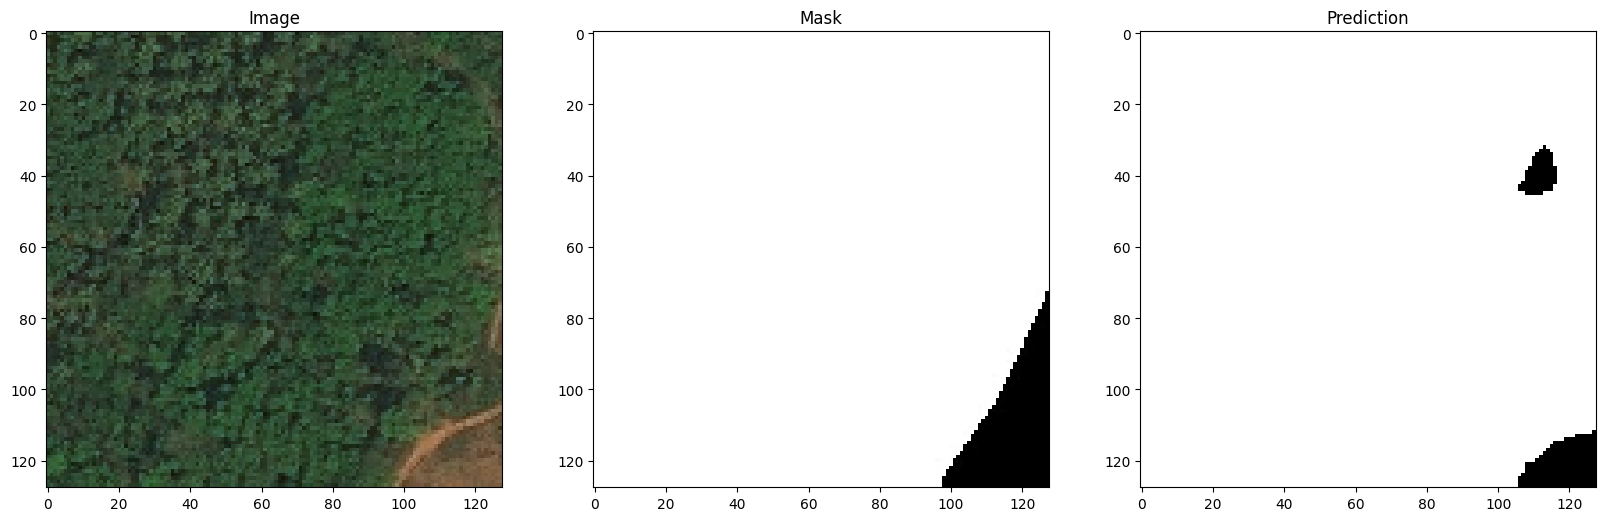

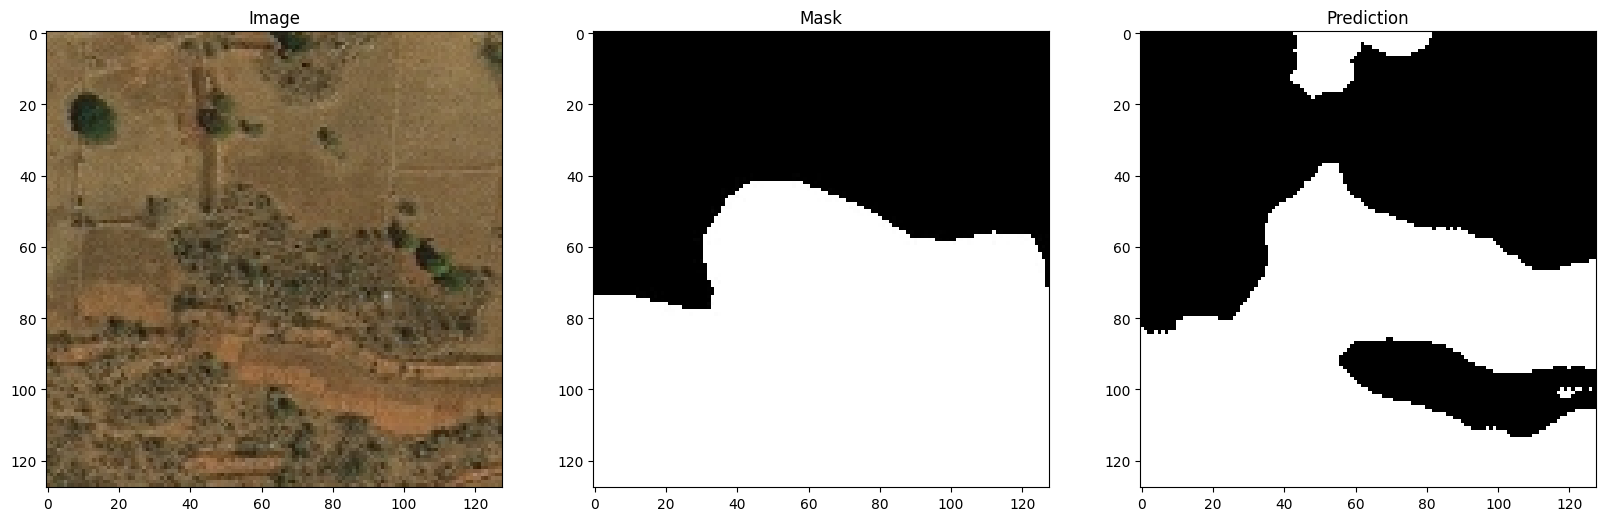

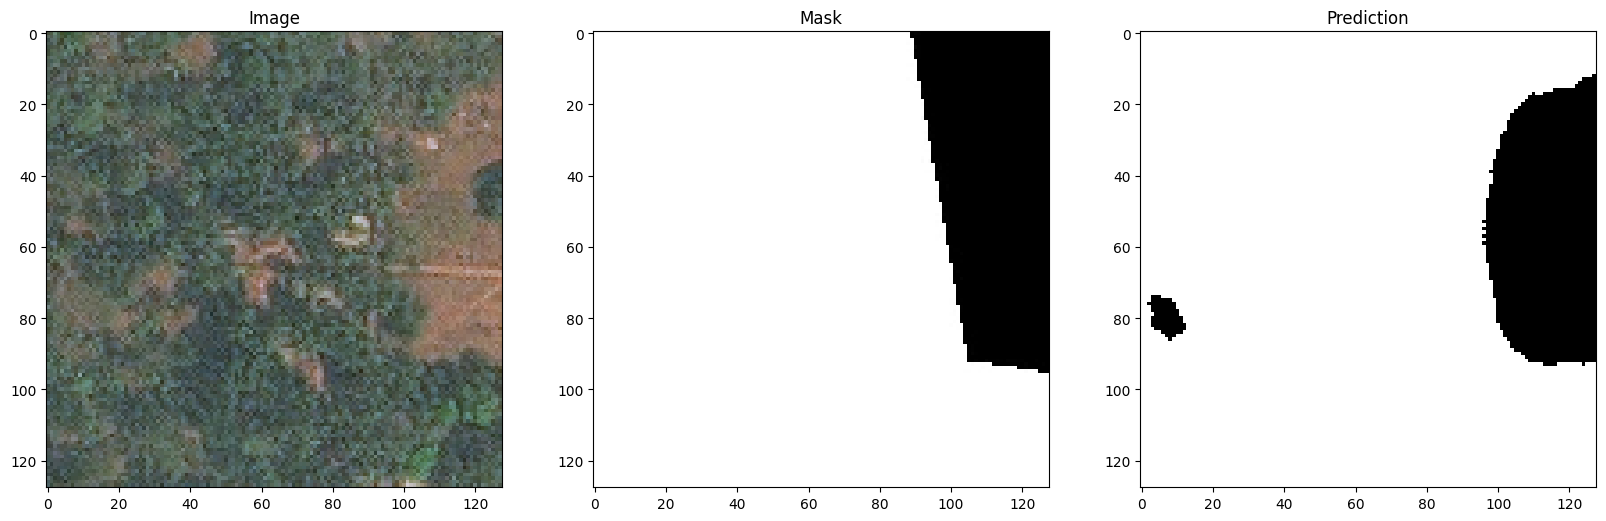

In [10]:
# Show samples
for i in range(3):
    plot_sample(X_val, Y_val, preds, index=i)